In [40]:
import numpy as np
import xraylib as xrl
import matplotlib.pyplot as plt
from tqdm import tqdm

import fresnel

In [48]:
# photon energy 
energy = 12.5 # keV
wavelength = 1.2398 / (energy * 1e3) * 1e-3 # mm
    
# material parameters
density_Ge = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Ge'))
density_Polyimide = 1.42
density_Si = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Si'))
n_Ge = xrl.Refractive_Index('Ge', energy, density_Ge)
n_Si = xrl.Refractive_Index('Si', energy, density_Si)
n_PI = xrl.Refractive_Index('Kapton Polyimide Film', energy, density_Polyimide)

# geometry and discretization
wg_radius = 24e-6
xtot = 100e-6 # mm
ytot = 100e-6 # mm
ztot = 0.05 # mm

nx = 500
ny = 200
nz = 800

# define waveguide
n_clad = n_Ge
n_core = n_PI

# calculate refractive index
xx = np.linspace(-xtot/2, xtot/2, nx)[np.newaxis, :]
yy = np.linspace(-ytot/2, ytot/2, ny)[:, np.newaxis]
zz = np.linspace(0, ztot, nz, endpoint=False)
core = (np.sqrt(xx**2 + yy**2) < wg_radius)
cladding = ~core

refractive_index = n_clad * cladding + n_core * core

# units
dx = xtot / nx / wavelength
dy = ytot / ny / wavelength
dz = ztot / nz / wavelength
print(f"dx: {dx}, dy: {dy}, dz: {dz} wavelengths")

# initial value (incoming field)
u0 = 1 * np.ones((ny, nx), dtype=np.complex128)

dx: 2.0164542668172287, dy: 5.041135667043071, dz: 630.1419583803839 wavelengths


## finite-difference method

In [49]:
# boundary conditions
# use exact solution (of paraxial Helmholtz equation) for homogeneous object
k0 = 2 * np.pi
zz_ul = zz / wavelength # unitless
boundary_layer = np.exp(1j * k0 / 2 * (n_clad**2 - 1) * zz_ul)

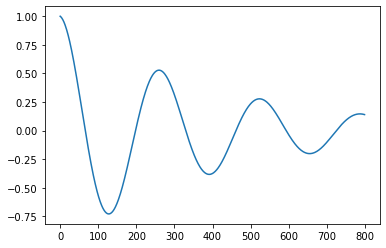

In [50]:
fig, ax = plt.subplots()
ax.plot(boundary_layer.real)

In [51]:
propagator = fresnel.FDPropagator3d(refractive_index, u0, dz, dy, dx)

In [52]:
field = np.zeros((nz, ny, nx), dtype=np.complex128)

field[0,...] = u0

for iz in tqdm(range(1, nz)):
    boundary = 4 * (boundary_layer[iz],)
    field[iz, ...] = propagator.step(refractive_index, boundary)

100%|██████████| 799/799 [00:06<00:00, 119.30it/s]


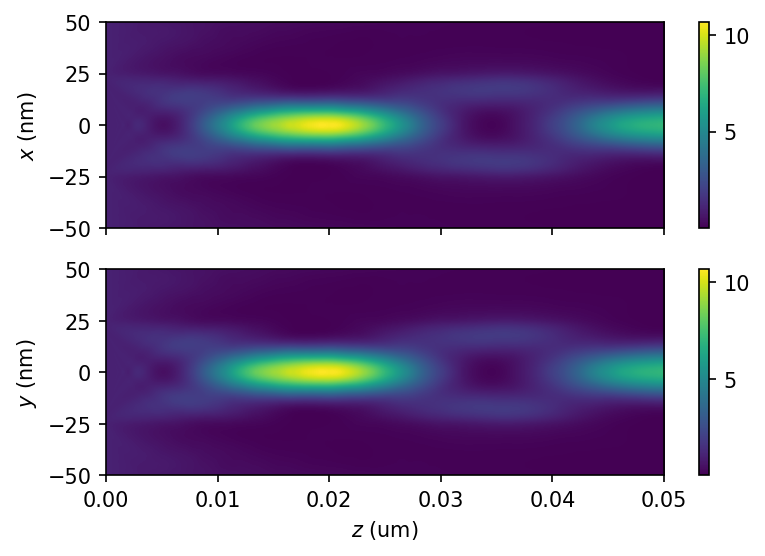

In [47]:

fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, sharex=True)

result = field[:,ny//2, :].transpose().copy()
im1 = ax1.imshow(np.abs(result)**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6])
#ax.set_ylim(-50, 50 )
#im1.set_clim(0, 10)
ax1.set_ylabel(r'$x$ (nm)')
fig.colorbar(im1, ax=ax1)

result = field[:,:, nx//2].transpose().copy()
im2 = ax2.imshow(np.abs(result)**2, aspect='auto', cmap='viridis', extent=[0, ztot, -ytot/2 *1e6, ytot/2 * 1e6])
#ax.set_ylim(-50, 50 )
#im2.set_clim(0, 10)
ax2.set_xlabel(r'$z$ (um)')
ax2.set_ylabel(r'$y$ (nm)')
fig.colorbar(im2, ax=ax2)

In [16]:
del field

## Multislice approach

In [17]:
multislicepropagator = fresnel.MultislicePropagator(u0, (dz, dy, dx))

In [18]:
field = np.zeros((nz, ny, nx), dtype=np.complex128)

field[0,...] = u0

for iz in tqdm(range(1, nz)):
    field[iz, ...] = multislicepropagator.step(refractive_index)

100%|██████████| 799/799 [00:17<00:00, 45.36it/s]


In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=150, sharex=True)

result = field[:,ny//2, :].transpose().copy()
im1 = ax1.imshow(np.abs(result)**2, aspect='auto', cmap='viridis', extent=[0, ztot, -xtot/2 *1e6, xtot/2 * 1e6])
#ax.set_ylim(-50, 50 )
im1.set_clim(0, 10)
ax1.set_ylabel(r'$x$ (nm)')
fig.colorbar(im1, ax=ax1)

result = field[:,:, nx//2].transpose().copy()
im2 = ax2.imshow(np.abs(result)**2, aspect='auto', cmap='viridis', extent=[0, ztot, -ytot/2 *1e6, ytot/2 * 1e6])
#ax.set_ylim(-50, 50 )
im2.set_clim(0, 10)

ax2.set_xlabel(r'$z$ (um)')
ax2.set_ylabel(r'$y$ (nm)')

fig.colorbar(im2, ax=ax2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …